In [ ]:
# RNN 모델로 시계열 데이터 예측
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [5]:
# 앞서 DNN으로 한것과 다 같고 레이어 구성 부분만 RNN으로 바꾼거다.
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
# 적절한 입력 양식으로 데이터 조각조각
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # 전체 데이터를 'window_size' 크기의 시퀀스로 만들어주기. 01234, 12345, 23456... 등으로
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # 순서 유지를 위해 평평하게 펼쳐야 한다는데 어...아직은 이해가 안된다. 

  print(np.array(dataset))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1) # 각 window_size만큼 나눠진 애들 내부에 있는 데이터들을 prefetch에 전달된 매개변수 크기만큼 묶어주기
  return dataset # 정리된 애들을 반환

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # 람다 레이어를 사용하면 입력 양식을 RNN의 입력값에 맞게 설정할 수 있다. RNN의 입력 양식 중 마지막 양식이 시계열 데이터의 차원이 한개인가 두개인가 적어야 하는 부분이 있는데 입력 데이터에는 그게 없다. 람다 레이어는 입력 데이터에 그 정보를 추가할 수 있게 양식을 조정해주는 기능을 부여할 수 있다. 즉, 람다식을 사용할 수 있게 해주는 레이어란 뜻. 
                      input_shape=[None]),
                      # RNN 추가. return_sequences=true면 매 타임스탬프마다 출력될 아웃풋을 다 출력하며 이를 그대로 다음 RNN의 입력에 넣는다. 
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40), # 여기선 return_sequences가 없다. 기본값은 false며 이렇게 되면 가장 마지막 타임 때 얻은 값을 Dense Layer의 인풋으로 사용하는 것이다. 
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0) # 여기선 각 값을 100배 늘렸다. 이거 설명하면서 RNN의 활성화 함수가 tanh라고 하시던데 음...어떤 관계가 있는건지 잘 모르겠다. 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # 학습률 보고 
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9) # 최적화 방법. 학습률 필수 기입
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]) # 절대값 오차
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None,), types: tf.float32>
Epoch 1/100
8/8 [==============================] - 1s 10ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 195.2579 - mae: 195.7579
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 192.3058 - mae: 192.8058
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 187.5113 - mae: 188.0113
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 185.2976 - mae: 185.7976
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 183.4113 - m

(1e-08, 0.0001, 0.0, 30.0)

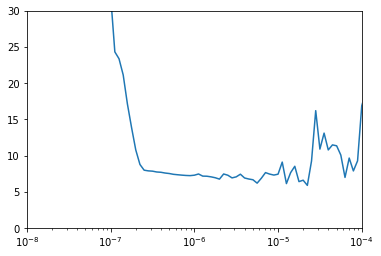

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"]) # 학습률에 따른 손실 정도를 그래프로 나타낸 것. 이거 보고 학습률 재조정해서 다시 학습시키면 된다. 내가 봤을 때 우선 적은 에포크로 슥 돌려보고 학습률에 따른 오차 확인한 다음 제일 낮은 손실이 나올 학습률을 사용해 에포크를 크게 하고 제대로 훈련시키는 방식을 취하는게 아닌가 싶다. 
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
# 앞서 확인한 학습률 대비 손실 그래프 보고 최적의 학습률 선정
tf.keras.backend.clear_session() # 이미 모델이 담겨있는 model에 쌓인 레이어 등의 정보를 싹 날려보낸다. 이렇게 해야 메모리가 불필요하게 쌓이는 일을 방지할 수 있다. 
tf.random.set_seed(51)
np.random.seed(51)

# 데이터 크기 
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size) # 새로 셔플한 dataset 생성

# 모델 생성
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

===========================] - 0s 6ms/step - loss: 5.8006 - mae: 6.2828
Epoch 189/400
8/8 [==============================] - 0s 6ms/step - loss: 6.6744 - mae: 7.1601
Epoch 190/400
8/8 [==============================] - 0s 6ms/step - loss: 6.5934 - mae: 7.0789
Epoch 191/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9471 - mae: 5.4284
Epoch 192/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4585 - mae: 4.9325
Epoch 193/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5150 - mae: 4.9890
Epoch 194/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7815 - mae: 5.2610
Epoch 195/400
8/8 [==============================] - 0s 6ms/step - loss: 4.8873 - mae: 5.3692
Epoch 196/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4998 - mae: 4.9733
Epoch 197/400
8/8 [==============================] - 0s 5ms/step - loss: 4.4237 - mae: 4.8979
Epoch 198/400
8/8 [==============================] - 0s 6ms/step - loss: 4.1426 - 

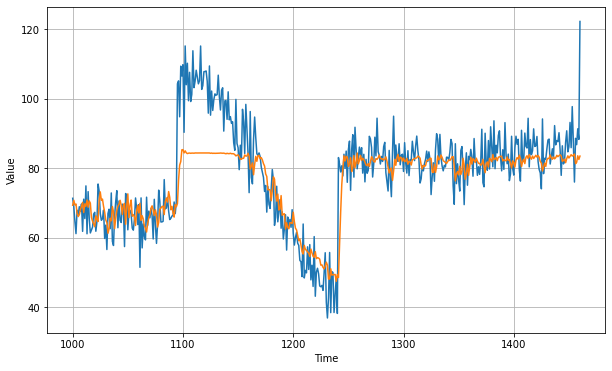

In [18]:
# 값 예측
forecast=[]
for time in range(len(series) - window_size): # 마지막 window_size만큼을 예측
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.412186

<Figure size 432x288 with 0 Axes>

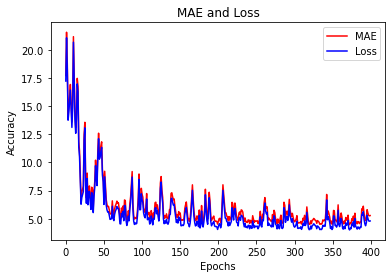

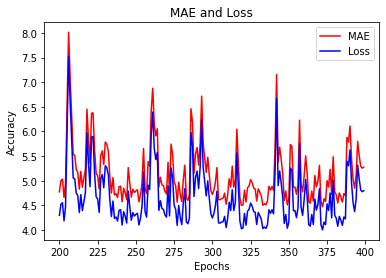

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# 손실(오차) 비교
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()